# Predictive Maintenance for NASA Industrial Machinery

## Objective
The objective for this project is to train and build a machine learning model to predict machine equipment failures or maintenance needs based on sensor data and historical maintenance records, and deploy it as an interactive web application using the DASH framework. The web side of the application will be deployed on render.com

## Case Study Context
We as a group decided to cater the Predictive Maintenance topic towards a specific case scenario. This model will specifically be used to predict maintenance in the aerospace field. We will ustilise the NASA Turbofan Jet Engine Dataset found on kaggle to predict the remaining life span of equipment, or more commonly known as the remaining useful like (RUL). We will also work on predicting whether maintenance is needed and when maintenance will be required. 

## Dataset Description
The dataset simulates jet engine degradation under various operating conditions. It includes four subsets (FD001–FD004), each with different fault modes and operating conditions. It can be found on kaggle: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps. The NASA Turbofan Jet Engine Dataset contains 4 subsets of data. This includes FD001 - FD004. Each subset has a RUL datafile, a test datafile, and a train datafile. For this specific project FD001 will be utilised due to it being the simplest subset, its single fault mode, and its constant operating conditions. This will assist with manageability. At a later stage we will look into training subset FD002-FD004.

## Libraries Used

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
import time
warnings.filterwarnings('ignore')

## Loading the Data (FD001)
Currently the data is in a single columnar textfile. We need to break it down into a tabular format. The data is separated into the column headings 'unit', 'cycle','setting1','setting2','setting3', and then 'sensor(i)' with i being 1 to and including 21. 

In [68]:
columns = ['unit', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
train_data = pd.read_csv('../dataset/train_FD001.txt', sep='\s+', header=None, names=columns)
test_data = pd.read_csv('../dataset/test_FD001.txt', sep='\s+', header=None, names=columns)
rul_data = pd.read_csv('../dataset/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [69]:
df = train_data

In [70]:
df.head()

,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [71]:
df.tail()

,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,519.30,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   sensor1   20631 non-null  float64
 6   sensor2   20631 non-null  float64
 7   sensor3   20631 non-null  float64
 8   sensor4   20631 non-null  float64
 9   sensor5   20631 non-null  float64
 10  sensor6   20631 non-null  float64
 11  sensor7   20631 non-null  float64
 12  sensor8   20631 non-null  float64
 13  sensor9   20631 non-null  float64
 14  sensor10  20631 non-null  float64
 15  sensor11  20631 non-null  float64
 16  sensor12  20631 non-null  float64
 17  sensor13  20631 non-null  float64
 18  sensor14  20631 non-null  float64
 19  sensor15  20631 non-null  float64
 20  sensor16  20631 non-null  fl

## Exploratory Data Analysis (EDA)

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


### Sensor trends for engine 1:

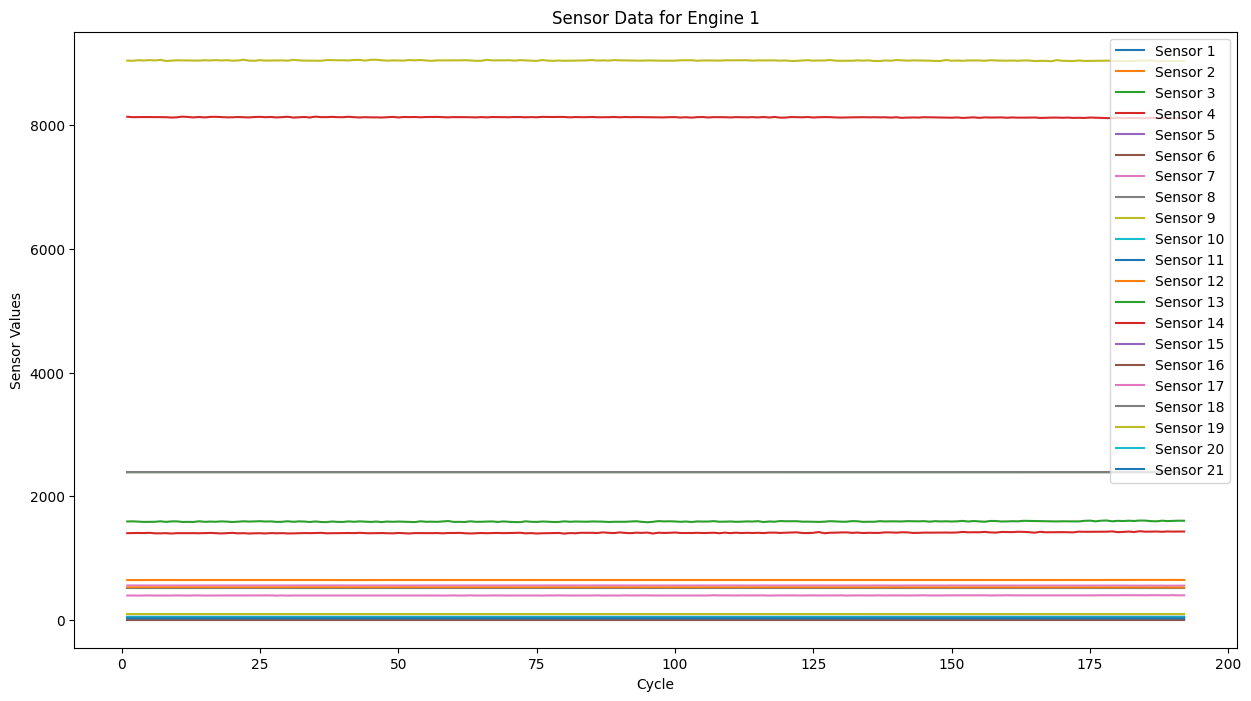

In [74]:
engine_1 = df[df['unit'] == 1]
plt.figure(figsize=(15, 8))
plt.plot(engine_1['cycle'], engine_1['sensor1'], label='Sensor 1')
plt.plot(engine_1['cycle'], engine_1['sensor2'], label='Sensor 2')
plt.plot(engine_1['cycle'], engine_1['sensor3'], label='Sensor 3')
plt.plot(engine_1['cycle'], engine_1['sensor4'], label='Sensor 4')
plt.plot(engine_1['cycle'], engine_1['sensor5'], label='Sensor 5')
plt.plot(engine_1['cycle'], engine_1['sensor6'], label='Sensor 6')
plt.plot(engine_1['cycle'], engine_1['sensor7'], label='Sensor 7')
plt.plot(engine_1['cycle'], engine_1['sensor8'], label='Sensor 8')
plt.plot(engine_1['cycle'], engine_1['sensor9'], label='Sensor 9')
plt.plot(engine_1['cycle'], engine_1['sensor10'], label='Sensor 10')
plt.plot(engine_1['cycle'], engine_1['sensor11'], label='Sensor 11')
plt.plot(engine_1['cycle'], engine_1['sensor12'], label='Sensor 12')
plt.plot(engine_1['cycle'], engine_1['sensor13'], label='Sensor 13')
plt.plot(engine_1['cycle'], engine_1['sensor14'], label='Sensor 14')
plt.plot(engine_1['cycle'], engine_1['sensor15'], label='Sensor 15')
plt.plot(engine_1['cycle'], engine_1['sensor16'], label='Sensor 16')
plt.plot(engine_1['cycle'], engine_1['sensor17'], label='Sensor 17')
plt.plot(engine_1['cycle'], engine_1['sensor18'], label='Sensor 18')
plt.plot(engine_1['cycle'], engine_1['sensor19'], label='Sensor 19')
plt.plot(engine_1['cycle'], engine_1['sensor20'], label='Sensor 20')
plt.plot(engine_1['cycle'], engine_1['sensor21'], label='Sensor 21')

plt.xlabel('Cycle')
plt.ylabel('Sensor Values')
plt.title('Sensor Data for Engine 1')
plt.legend()
plt.show()

### Correlation Heatmap

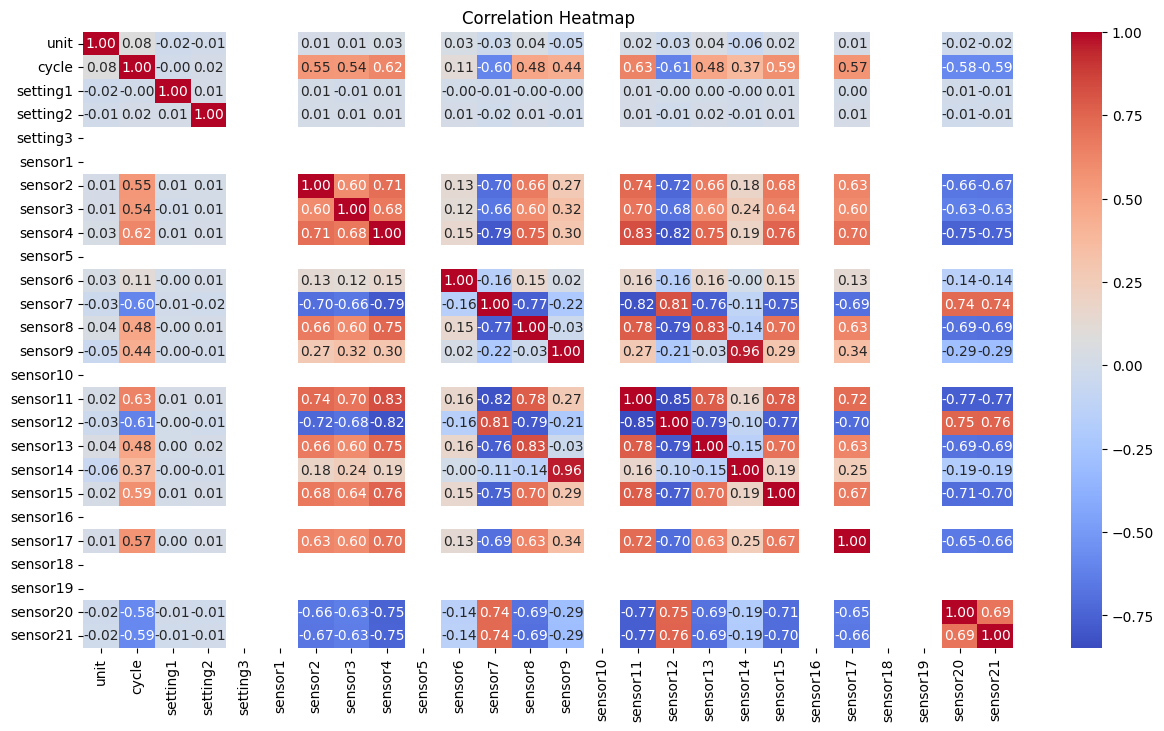

In [75]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Che3ck for variances

In [76]:
variance = df.var()
print("Low Variance Sensors (std < 0.01):\n",variance[variance < 0.01])

Low Variance Sensors (std < 0.01):
 setting1    4.784340e-06
setting2    8.588541e-08
setting3    0.000000e+00
sensor1     4.273435e-21
sensor5     1.152399e-23
sensor6     1.929279e-06
sensor8     5.038938e-03
sensor10    2.172333e-25
sensor13    5.172330e-03
sensor15    1.406628e-03
sensor16    2.422479e-28
sensor18    0.000000e+00
sensor19    0.000000e+00
dtype: float64


The variance output confirms that several features have extremely low variance (std < 0.01), meaning they are nearly constant and unlikely to contribute meaningfully to predicting Remaining Useful Life (RUL) or maintenance needs

In FD001, the operational settings are meant to represent conditions like altitude or Mach number, which can influence engine degradation. However, FD001 is designed with constant operating conditions (as noted in the dataset description). This is reflected in the variance: setting3 has zero variance (std = 0), meaning it’s completely constant (always 100.0, as seen in df.head() and df.tail()), and setting1 and setting2 have variances so small (on the order of 10^-6 and 10^-8) that their fluctuations are negligible. This allows the removal of settings1-3

## Data Cleaning

In [77]:
drop_features = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor8', 'sensor13', 'sensor15', 'sensor16', 'sensor18', 'sensor19']
df = df.drop(columns=drop_features)
test_data = test_data.drop(columns=drop_features)

## Feature Engineering

In [78]:
df['RUL'] = df.groupby('unit')['cycle'].transform(lambda x: x.max() - x)
df['failure_30'] = (df['RUL'] <= 30).astype(int)

## Preprocessing

In [79]:
features = [col for col in df.columns if col not in ['unit', 'cycle', 'RUL', 'failure_30']]
X = df[features]
y = df['RUL']

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Development

In [82]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100],
    'max_depth': [5,10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10], 'n_estimators': [100]},
             scoring='neg_mean_squared_error')

In [83]:
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}


In [84]:
y_pred = best_model.predict(X_val)
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

RMSE: 41.38200544460438
MAE: 29.582948369609188
R²: 0.6251811849979007


This is just a test block where I wanted to compare multiple models. 

In [85]:
models = {
    'RandomForest': RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    y_val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    y_test_pred = model.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(rul_data['RUL'], y_test_pred))

    results.append({
        'Model': model_name,
        'Training Time (s)': training_time,
        'Val RMSE': val_rmse,
        'Val MAE': val_mae,
        'Val R²': val_r2,
        'Test RMSE': test_rmse
    })
    
    print(f"{model_name} - Val RMSE: {val_rmse:.2f}, Test RMSE: {test_rmse:.2f}, Time: {training_time:.2f}s")

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

best_model_name = results_df.loc[results_df['Test RMSE'].idxmin(), 'Model']
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with Test RMSE: {results_df['Test RMSE'].min():.2f}")


Training RandomForest...
RandomForest - Val RMSE: 41.38, Test RMSE: 32.76, Time: 1.47s

Training LinearRegression...
LinearRegression - Val RMSE: 44.50, Test RMSE: 32.59, Time: 0.01s

Training SVR...
SVR - Val RMSE: 42.06, Test RMSE: 27.98, Time: 7.58s

Training XGBoost...
XGBoost - Val RMSE: 44.90, Test RMSE: 39.43, Time: 0.70s

Training MLP...
MLP - Val RMSE: 41.60, Test RMSE: 34.45, Time: 49.90s

Model Comparison:
              Model  Training Time (s)   Val RMSE    Val MAE    Val R²  \
0      RandomForest           1.465446  41.382005  29.582948  0.625181   
1  LinearRegression           0.008884  44.500717  34.156130  0.566557   
2               SVR           7.576113  42.064389  29.727729  0.612718   
3           XGBoost           0.702461  44.902624  32.076762  0.558692   
4               MLP          49.898467  41.595761  30.052160  0.621299   

   Test RMSE  
0  32.760229  
1  32.591021  
2  27.976734  
3  39.433390  
4  34.454259  

Best Model: SVR with Test RMSE: 27.98


In [86]:
joblib.dump(best_model, 'model.pkl')

['model.pkl']

In [87]:
test_last = test_data.groupby('unit').last().reset_index()
X_test = test_last[features]
X_test_scaled = scaler.transform(X_test)
y_test_pred = best_model.predict(X_test_scaled)
print("Test RMSE:", np.sqrt(mean_squared_error(rul_data['RUL'], y_test_pred)))

Test RMSE: 27.976734060265194
